# Pymob quickstart

## Initialize a simulation

In pymob a Simulation object is initialized by calling the {class}`pymob.simulation.SimulationBase` class from the simulation module.

In [13]:
from pymob.simulation import SimulationBase

sim = SimulationBase()

```{admonition} Configuring the simulation
:class: note
Optionally, we can configure the simulation at this stage with 
`sim.config.case_study.name = "linear-regression"`, `sim.config.case_study.scenario = "test"`, and many more options. 
```

## Define a model 

Let's investigate a linear regression as the most simple task.

In [14]:
def linreg(x, a, b):
    return a + x * b

So we assume that this model describes our data well. So we add it to the simulation

In [15]:
sim.model = linreg


## Defining a solver

In our case the model gives the exact solution of the model.
Solvers in pymob are callables that need to return a dictionary of results mapped to the data variables


In [16]:
from pymob.sim.solvetools import solve_analytic_1d
sim.solver = solve_analytic_1d


## Generate artificial data

In the real world, you will have measured a dataset. For demonstration, we define parameters $theta$, that we assume describe the true data generating process and generate observations $y$. Then we
generate data for $x$ on [-5, 5] and add random noise with a standard deviation of $\sigma_y = 1$.

In [17]:
import numpy as np
rng = np.random.default_rng(1)

# define the coordinates of the x-dimension to generate data for
x = np.linspace(-5, 5, 50)

# define a set of parameters θ
theta = dict(a=0, b=1, sigma_y=1)

# then simulate some data and add some noise
y = linreg(x=x, a=theta["a"], b=theta["b"])
y_noise = rng.normal(loc=y, scale=theta["sigma_y"])

## The pymob magic 🪄

So far we have not done anythin special. Pymob exists, because wrangling dimensions of input and output data, nested data-structures, missing data is painful. We avoid most of the mess by using `xarray` as a common input/output format. So we have to transform our data into a `xarray.Dataset` and add it to the simulation.

In [18]:
import xarray as xr

sim.observations = xr.DataArray(y_noise, coords={"x": x}).to_dataset(name="y")

MinMaxScaler(variable=y, min=-5.690912333645177, max=5.891166954282328)


/home/flo-schu/projects/pymob/pymob/simulation.py:304: UserWarning: `sim.config.data_structure.y = Datavariable(dimensions=['x'] min=-5.690912333645177 max=5.891166954282328 observed=True dimensions_evaluator=None)` has been assumed from `sim.observations`. If the order of the dimensions should be different, specify `sim.config.data_structure.y = DataVariable(dimensions=[...], ...)` manually.
  warnings.warn(


This worked 🎉 `sim.config.data_structure` will now give us some information about the layout of our data, which will handle the data transformations in the background.

```{admonition} What happens when we assign a Dataset to the observations attribute?
:class: hint

Debug into the function and discover what happens!
```

We can give `pymob` additional information about the data structure of our observations and intermediate (unobserved) variables that are simulated. This can be done with `sim.config.data_structure.y = DataVariable(dimensions=["x"])`.
These information can be used to switch the dimensional order of the observations or provide data variables that have differing dimensions from the observations, if needed. But if the dataset is ordinary, simply setting `sim.observations` property with a `xr.Dataset` will be sufficient.

```{admonition} Scalers
:class: note
We also notice a mysterious Scaler message. This tells us that our data variable has been identified and a scaler was constructed, which transforms the variable between [0, 1]. This has no effect at the moment, but it can be used later. Scaling can be powerful to help parameter estimation in more complex models.
```

## Parameterizing a model

Parameters are specified via the `FloatParam` or `ArrayParam` class. Parameters can be marked free or fixed depending on whether they should be variable during an optimization procedure.

In [19]:
from pymob.sim.config import Param
sim.config.model_parameters.a = Param(value=0, free=False)
sim.config.model_parameters.b = Param(value=3, free=True)
# this makes sure the model parameters are available to the model.
sim.model_parameters["parameters"] = sim.config.model_parameters.value_dict


`sim.model_parameters` is a dictionary that holds the model input data. The keys it takes by default are `parameters`, `y0` and `x_in`. In our case, we have a analytic model and need only `parameters`. In situations, where initial values for variables are needed, they can be provided with `sim.model_parameters["y0"] = ...`. 

```{admonition} generating input for solvers
:class: note
A helpful function to generate `y0` or `x_in` from observations is `SimulationBase.parse_input`, combined with settings of `config.simulation.y0`
```


## Running the model 🏃

The model is prepared with a parameter set and executed with 

In [20]:
# put everything in place for running the simulation
sim.dispatch_constructor()

# run
evaluator = sim.dispatch(theta={"b":3})
evaluator()
evaluator.results

/home/flo-schu/projects/pymob/pymob/simulation.py:546: UserWarning: The number of ODE states was not specified in the config file [simulation] > 'n_ode_states = <n>'. Extracted the return arguments ['a+x*b'] from the source code. Setting 'n_ode_states=1.
  warnings.warn(


<xarray.Dataset>
Dimensions:  (x: 50)
Coordinates:
  * x        (x) float64 -5.0 -4.796 -4.592 -4.388 ... 4.388 4.592 4.796 5.0
Data variables:
    y        (x) float64 -15.0 -14.39 -13.78 -13.16 ... 13.16 13.78 14.39 15.0

This returns a dataset which is of the exact same shape as the observation dataset, plus intermediate variables that were created during the simulation, if they are tracked by the solver.

Although this API seems to be a bit clunky, it is necessary, to make sure that simulations that are executed in parallel are isolated from each other.


## Estimating parameters 

We are almost set infer the parameters of the model. We add another parameter to also estimate the error of the parameters, We use a lognormal distribution for it. We also specify an error model for the distribution. This will be 

$$y_{obs} \sim Normal (y, \sigma_y)$$

In [21]:
sim.config.model_parameters.sigma_y = Param(free=True , prior="lognorm(scale=1,s=1)", min=0, max=1)
sim.config.model_parameters.b.prior = "lognorm(scale=1,s=1)"
sim.config.model_parameters.b.min = -5
sim.config.model_parameters.b.max = 5

sim.config.error_model.y = "normal(loc=y,scale=sigma_y)"

### Manual estimation

First, we try estimating the parameters by hand. For this we have a simple interactive backend.

In [22]:
from matplotlib import pyplot as plt
def plot(results: xr.Dataset):
    obs = sim.observations

    fig, ax = plt.subplots(1,1)
    ax.plot(results.x, results.y, lw=2, color="black")
    ax.plot(obs.x, obs.y, ls="", marker="o", color="tab:blue", alpha=.5)
    ax.set_xlim(-5,5)
    ax.set_ylim(-7.5,5.5)

In [23]:
sim.plot = plot
sim.interactive()

### Estimating parameters and uncertainty with MCMC

Of course this example is very simple, we can in fact optimize the parameters perfectly by hand. But just for the fun of it, let's use *Markov Chain Monte Carlo* (MCMC) to estimate the parameters, their uncertainty and the uncertainty in the data.

```{admonition} numpyro distributions
:class: warning
Currently only few distributions are implemented in the numpyro backend. This API will soon change, so that basically any distribution can be used to specifcy parameters. 
```

Finally, we let our inferer run the paramter estimation procedure with the numpyro backend and a NUTS kernel. This does the job in a few seconds

In [ ]:
sim.set_inferer("numpyro")
sim.inferer.config.inference_numpyro.kernel = "nuts"
sim.inferer.run()

sim.inferer.idata.posterior

Jax 64 bit mode: False
Absolute tolerance: 1e-07
Trace Shapes:     
 Param Sites:     
Sample Sites:     
       b dist    |
        value    |
 sigma_y dist    |
        value    |
   y_obs dist 50 |
        value 50 |


sample: 100%|██████████| 3000/3000 [00:01<00:00, 1949.09it/s, 1 steps of size 8.76e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b      0.97      0.04      0.97      0.90      1.05   1684.80      1.00
   sigma_y      0.91      0.09      0.90      0.76      1.07   1148.32      1.00

Number of divergences: 0


<xarray.Dataset>
Dimensions:  (chain: 1, draw: 2000)
Coordinates:
  * chain    (chain) int64 0
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 1993 1994 1995 1996 1997 1998 1999
Data variables:
    b        (chain, draw) float32 1.013 1.031 1.046 ... 0.9507 0.8844 0.8844
    sigma_y  (chain, draw) float32 0.8514 1.115 0.8677 ... 0.7915 0.9756 0.9756
Attributes:
    created_at:     2025-03-02T12:20:44.859786+00:00
    arviz_version:  0.20.0

We can inspect our estimates and see that the parameters are well esimtated by the model. Note that we only get an estimate for $b$. This is because earlier we set the parameter `a` with the flag `free=False` this effectively excludes it from estimation and uses the default value, which was set to the true value `a=0`.

### Plot the results

Pymob provides a very basic utility for plotting posterior predictions. We see that the mean is a perfect fit and also that the uncertainty in the data is correctly displayed. Fantstic 🎉

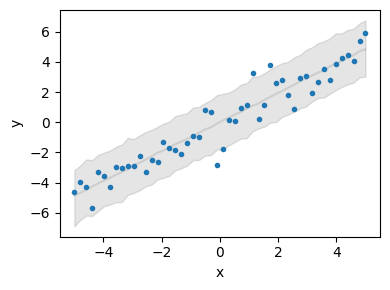

In [27]:
sim.config.simulation.x_dimension = "x"
sim.posterior_predictive_checks(pred_hdi_style={"alpha": 0.1})


```{admonition} Customize the posterior predictive checks
:class: hint
You can explore the API of {class}`pymob.sim.plot.SimulationPlot` to find out how you can work on the default predictions. Of course you can always make your own plot, by accessing {attr}`pymob.simulation.inferer.idata` and {attr}`pymob.simulation.observations`
```

### Report the results

```{admonition} numpyro distributions
:class: warning
Automated reporting is already implemented in a different branch. This will be soon explained here.
```

In [28]:
# TODO: Call report when done


## Exporting the simulation and running it via the case study API

After constructing the simulation, all settings of the simulation can be exported to a comprehensive configuration file, along with all the default settings. This is as simple as 

In [ ]:
import os
sim.config.case_study.name = "quickstart"
sim.config.case_study.scenario = "test"
sim.config.create_directory("scenario", force=True)
sim.config.create_directory("results", force=True)

# usually we expect to have a data directory in the case
os.makedirs(sim.data_path, exist_ok=True)
sim.save_observations(force=True)
sim.config.save(force=True)

The simulation will be saved to the default path (`CASE_STUDY/scenarios/SCENARIO/settings.cfg`) or to a custom path spcified with the `fp` keyword. `force=True` will overwrite any existing config file, which is the reasonable choice in most cases.

From there on, the simulation is (almost) ready to be executable from the commandline.

### Commandline API

The commandline API runs a series of commands that load the case study, execute the {meth}`pymob.simulation.SimulationBase.initialize` method and perform some more initialization tasks, before running the required job.

+ `pymob-infer`: Runs an inference job e.g. `pymob-infer --case_study=quickstart --scenario=test --inference_backend=numpyro`. While there are more commandline options, these are the two required 